In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

In [3]:
import utils as ut
early_stopping = ut.EarlyStopping(patience=100, verbose=1)

# 1. Create Data for Toy Problem

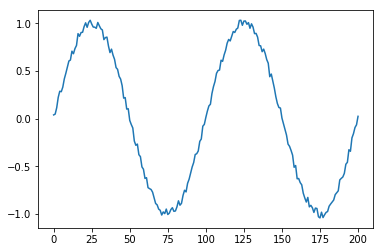

In [4]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*np.random.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 100
f = toy_problem(T)
plt.plot(f)

# 2a. Prepare Input Data to Train the Model

In [5]:
length_of_sequences = 2*T
maxlen = 25
data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

# 2b. Split Data into Training and Valdiation Set 

In [6]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
X_train, X_validation, Y_train, Y_validation = \
train_test_split(X, Y, test_size=N_validation)

# 3. Define Functions for Model

In [7]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y

def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step

# 4. Define TF Graph

In [13]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

tf.reset_default_graph()
# Input Parameters
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

# TF Variables


# 5. Run Computational Graph (with batches)

In [20]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break

epoch: 0  validation loss:  0.374976
epoch: 1  validation loss:  0.227226
epoch: 2  validation loss:  0.108322
epoch: 3  validation loss:  0.0557233
epoch: 4  validation loss:  0.0385493
epoch: 5  validation loss:  0.0298172
epoch: 6  validation loss:  0.0169131
epoch: 7  validation loss:  0.0119171
epoch: 8  validation loss:  0.00889161
epoch: 9  validation loss:  0.00676138
epoch: 10  validation loss:  0.005777
epoch: 11  validation loss:  0.00490913
epoch: 12  validation loss:  0.00435857
epoch: 13  validation loss:  0.00367919
epoch: 14  validation loss:  0.00354245
epoch: 15  validation loss:  0.00468984
epoch: 16  validation loss:  0.00386125
epoch: 17  validation loss:  0.00287334
epoch: 18  validation loss:  0.0051694
epoch: 19  validation loss:  0.00319127
epoch: 20  validation loss:  0.003065
epoch: 21  validation loss:  0.00260427
epoch: 22  validation loss:  0.00255011
epoch: 23  validation loss:  0.00288431
epoch: 24  validation loss:  0.00301046
epoch: 25  validation loss

epoch: 213  validation loss:  0.00200091
epoch: 214  validation loss:  0.00217685
epoch: 215  validation loss:  0.00212442
epoch: 216  validation loss:  0.00193874
epoch: 217  validation loss:  0.00204162
epoch: 218  validation loss:  0.00184806
epoch: 219  validation loss:  0.00211795
epoch: 220  validation loss:  0.00217015
epoch: 221  validation loss:  0.00229764
epoch: 222  validation loss:  0.00221496
epoch: 223  validation loss:  0.00189942
epoch: 224  validation loss:  0.00206968
epoch: 225  validation loss:  0.00214084
epoch: 226  validation loss:  0.00227816
epoch: 227  validation loss:  0.00219029
epoch: 228  validation loss:  0.00183163
epoch: 229  validation loss:  0.00212423
epoch: 230  validation loss:  0.00182975
epoch: 231  validation loss:  0.0022187
epoch: 232  validation loss:  0.00173564
epoch: 233  validation loss:  0.00212757
epoch: 234  validation loss:  0.00205585
epoch: 235  validation loss:  0.00181513
epoch: 236  validation loss:  0.00193216
epoch: 237  valid

# Computational Graph without Batches

In [ ]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    sess.run(train_step, feed_dict={
        x: X_[start:end],
        t: Y_[start:end],
        n_batch: N_train
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stoapping
    if early_bstopping.validate(val_loss):
        break

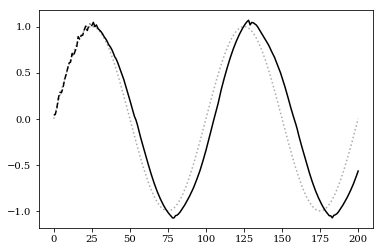

In [23]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

In [ ]:
cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
init_state = cell.zero_state(10, tf.float32)
state=init_state
outputs=[]
x=tf.placeholder(tf.float32, shape=[None, 2, 1])


In [ ]:
(cell_output, state) = cell(x[:, 0, :], state)

In [ ]:
X.shape

In [ ]:
with tf.variable_scope('RNN'):
    for t in range(maxlen):
        

In [ ]:
# For simplicty reasons, let us first implement a function that only has 2 lags
U = weight_variable([1, 1])
W = weight_variable([1, ])

h2 = tf.tanh(U)
V = weight_variable([n_hidden, 1])
c = bias_variable(1)
y = tf.matmul(h2, V) + c